# HDF5 dataset inference

/tmp/ipykernel_129126/2365326227.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('runs/generator.pt', map_location=device))


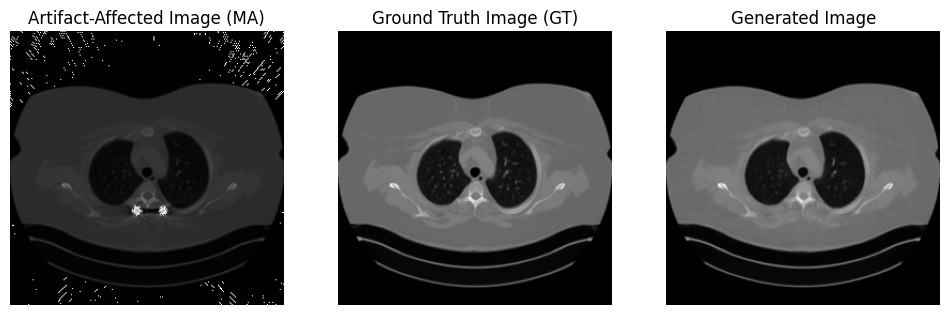

In [4]:
import torch
import h5py
import matplotlib.pyplot as plt
from torchvision import transforms
from generator import UnetGenerator  # Assuming the generator architecture is in generator.py
from PIL import Image

# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained generator model
generator = UnetGenerator().to(device)
generator.load_state_dict(torch.load('runs/generator.pt', map_location=device, weights_only=True))
generator.eval()  # Set model to evaluation mode

# Transformation to match training preprocessing (e.g., normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Inverse transform for visualization (to undo normalization)
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1], std=[2]),  # Reverse normalization if mean=0.5, std=0.5
    transforms.ToPILImage()
])

# Load and process the .h5 data file
def process_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        ma_image = f['ma_CT'][:]  # Artifact-affected image as a NumPy array
        gt_image = f['image'][:]  # Ground truth image as a NumPy array

    # Convert the NumPy arrays to PIL images
    ma_image = Image.fromarray(ma_image)
    gt_image = Image.fromarray(gt_image)

    # Apply transformations
    ma_tensor = transform(ma_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    gt_tensor = transform(gt_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Generate the cleaned image
    with torch.no_grad():
        generated_tensor = generator(ma_tensor)

    # Remove batch dimension and apply inverse transform for visualization
    ma_image = inverse_transform(ma_tensor.squeeze(0).cpu())
    gt_image = inverse_transform(gt_tensor.squeeze(0).cpu())
    generated_image = inverse_transform(generated_tensor.squeeze(0).cpu())

    return ma_image, gt_image, generated_image

# Visualization function
def visualize_images(ma_image, gt_image, generated_image):
    plt.figure(figsize=(12, 4))
    
    # Plot artifact-affected image
    plt.subplot(1, 3, 1)
    plt.imshow(ma_image, cmap="gray")
    plt.title("Artifact-Affected Image (MA)")
    plt.axis("off")

    # Plot ground truth image
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image, cmap="gray")
    plt.title("Ground Truth Image (GT)")
    plt.axis("off")

    # Plot generated image
    plt.subplot(1, 3, 3)
    plt.imshow(generated_image, cmap="gray")
    plt.title("Generated Image")
    plt.axis("off")

    plt.show()

# Path to the .h5 file
h5_file_path = "/home/maya/train_640reduced/000086_03_01/018/0.h5"  # Replace with the path to your .h5 file

# Process and visualize
ma_image, gt_image, generated_image = process_h5_file(h5_file_path)
visualize_images(ma_image, gt_image, generated_image)

# PNG images inference

In [2]:
!pip install -q torch_snippets torch_summary
from torch_snippets import *

In [7]:
from torchsummary import summary
summary(generator, torch.zeros(32,1,256,256));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        1,088
├─EncoderBlock: 1-2                      [-1, 128, 64, 64]         --
|    └─LeakyReLU: 2-1                    [-1, 64, 128, 128]        --
|    └─Conv2d: 2-2                       [-1, 128, 64, 64]         131,200
|    └─BatchNorm2d: 2-3                  [-1, 128, 64, 64]         256
├─EncoderBlock: 1-3                      [-1, 256, 32, 32]         --
|    └─LeakyReLU: 2-4                    [-1, 128, 64, 64]         --
|    └─Conv2d: 2-5                       [-1, 256, 32, 32]         524,544
|    └─BatchNorm2d: 2-6                  [-1, 256, 32, 32]         512
├─EncoderBlock: 1-4                      [-1, 512, 16, 16]         --
|    └─LeakyReLU: 2-7                    [-1, 256, 32, 32]         --
|    └─Conv2d: 2-8                       [-1, 512, 16, 16]         2,097,664
|    └─BatchNorm2d: 2-9                  [-1, 512, 16, 16]     

# Inference on images from the test set

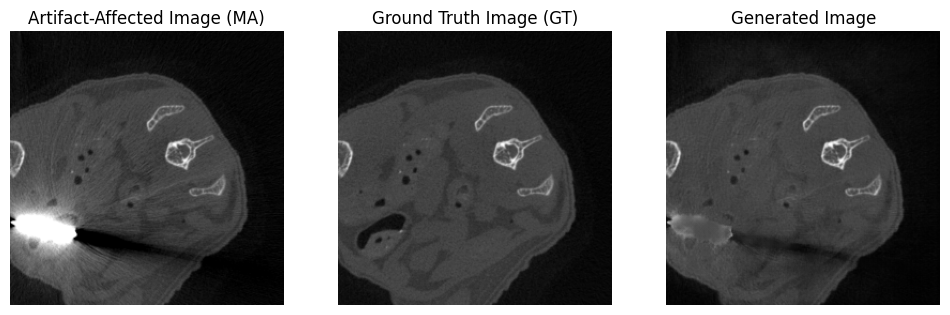

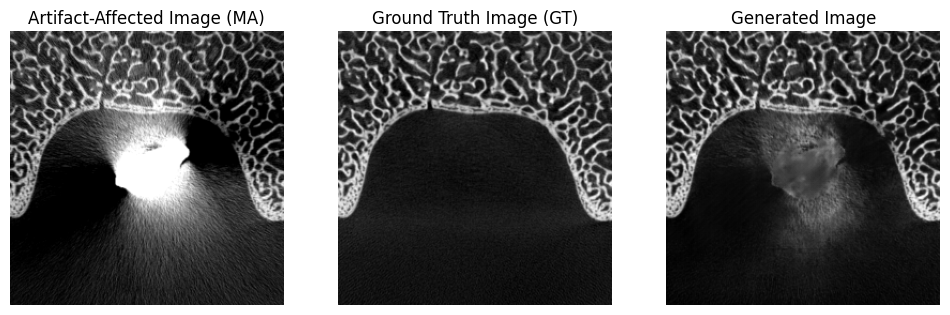

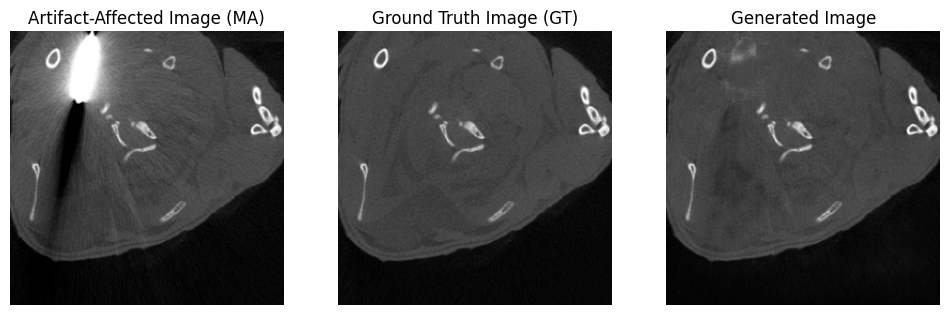

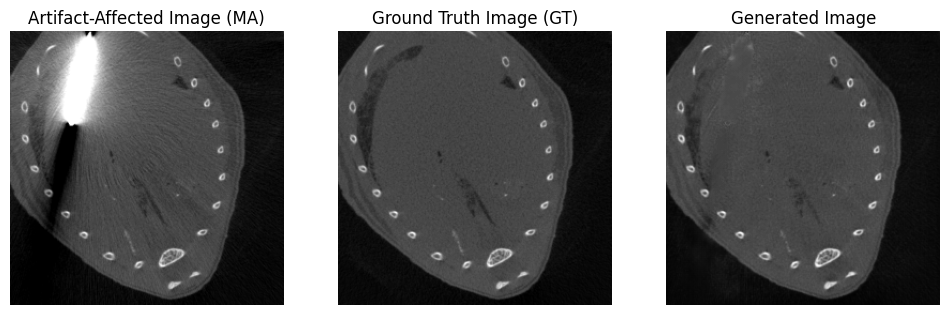

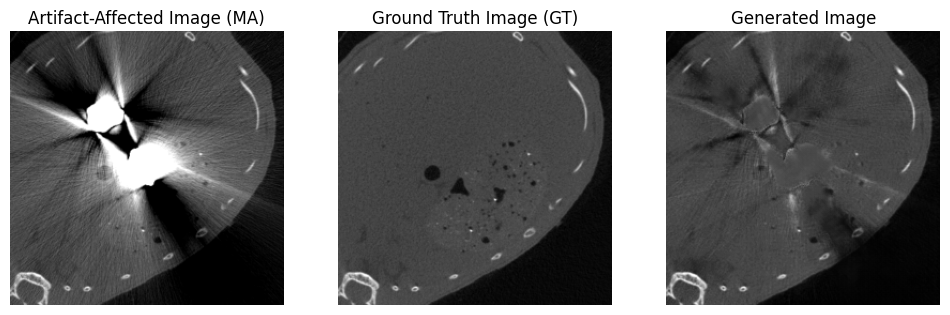

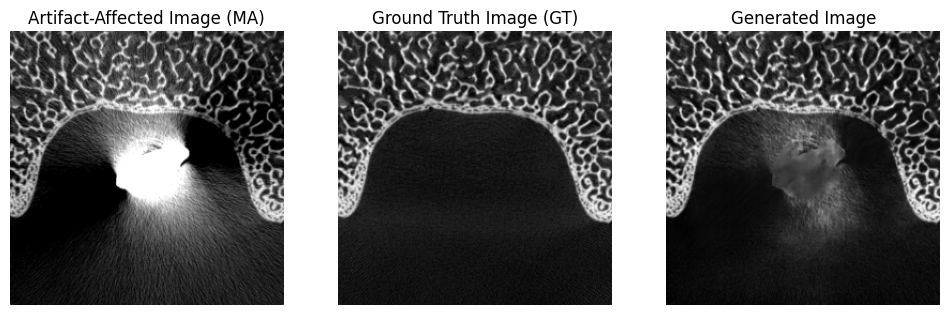

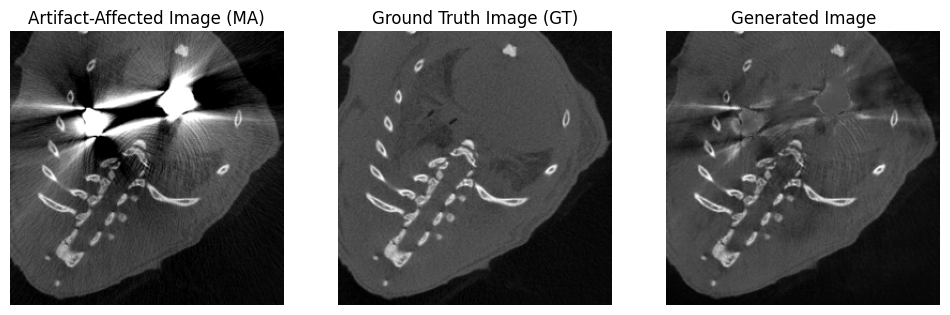

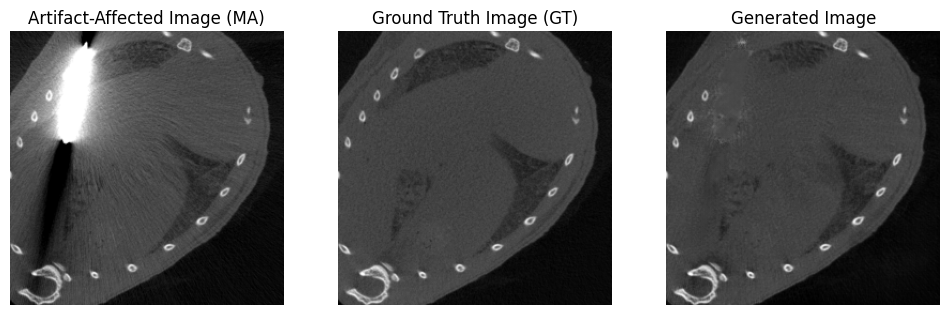

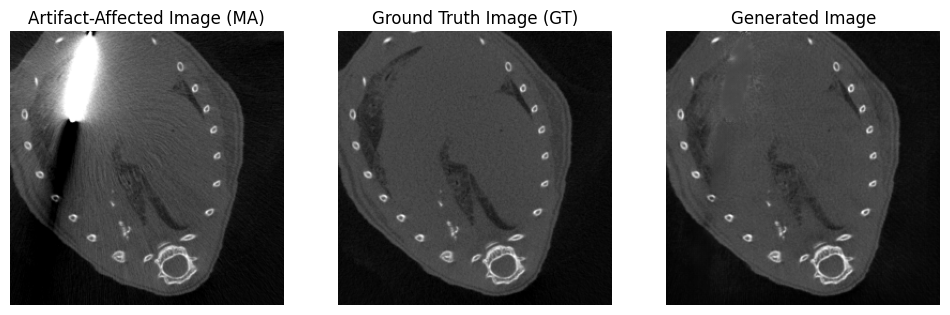

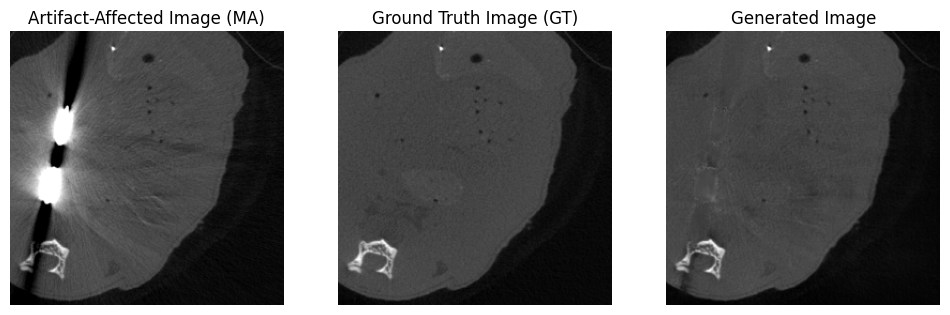

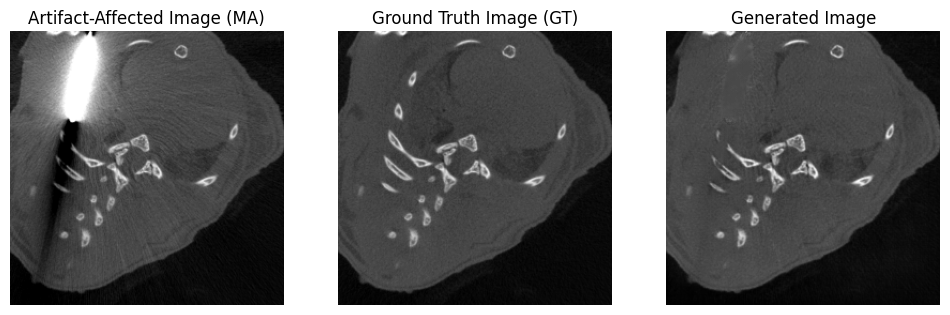

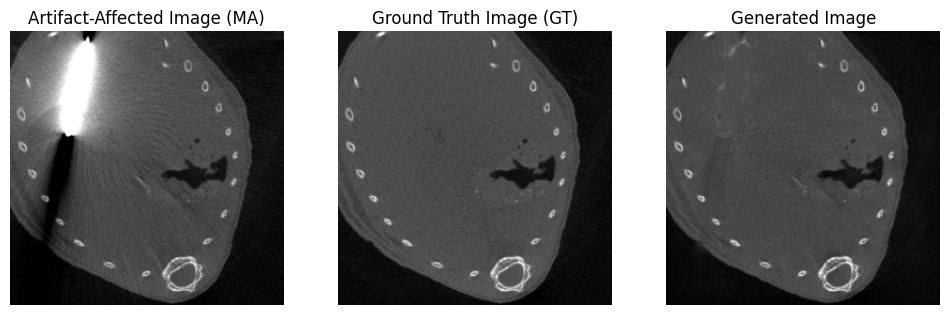

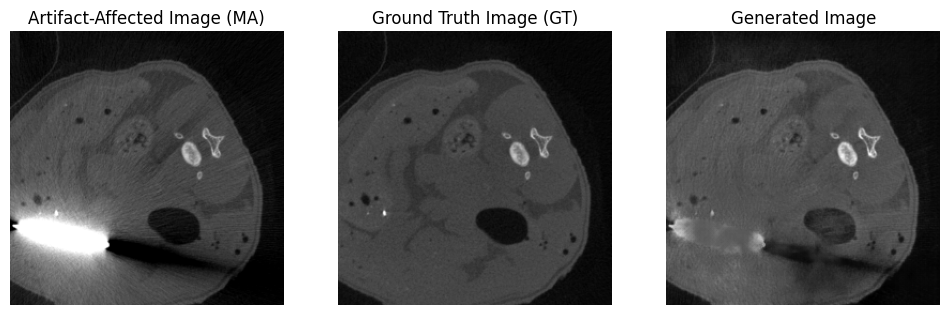

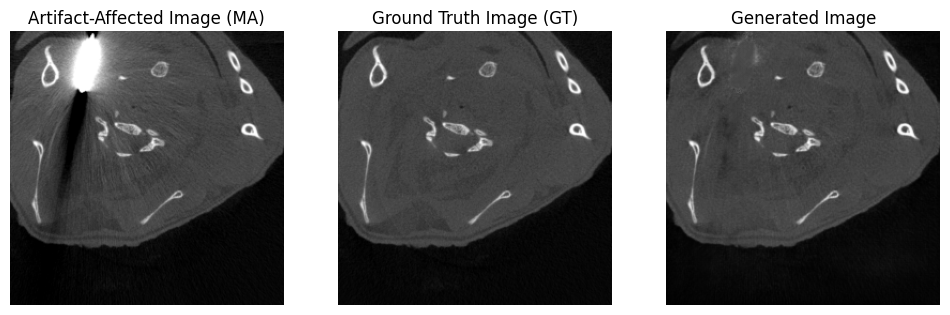

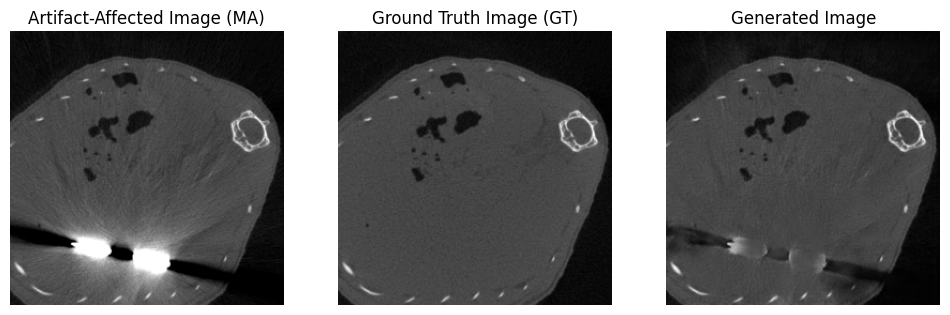

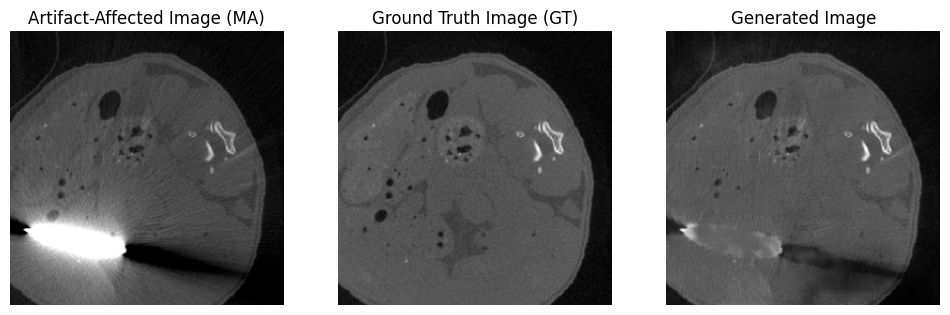

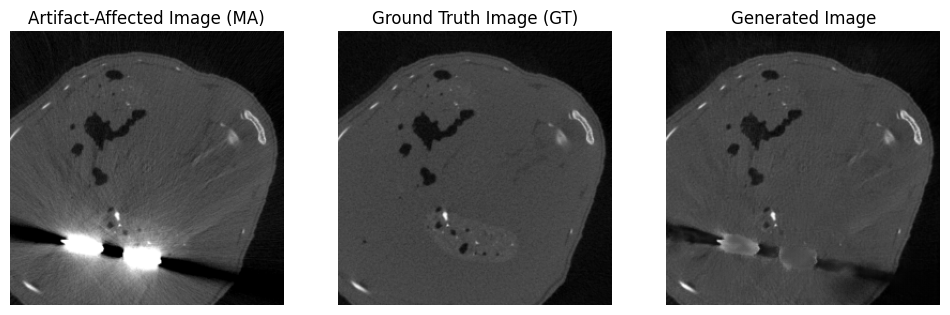

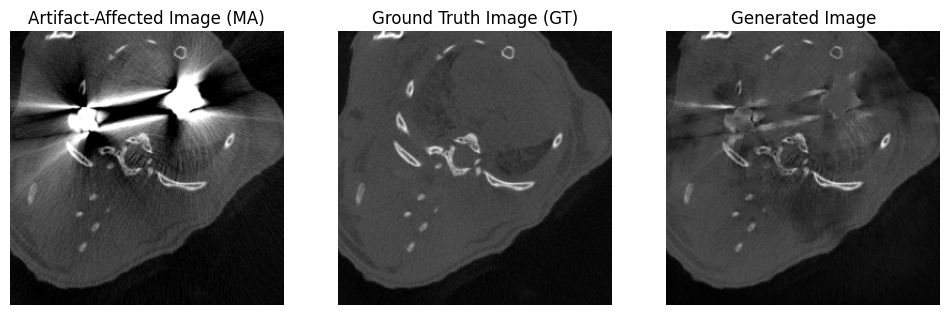

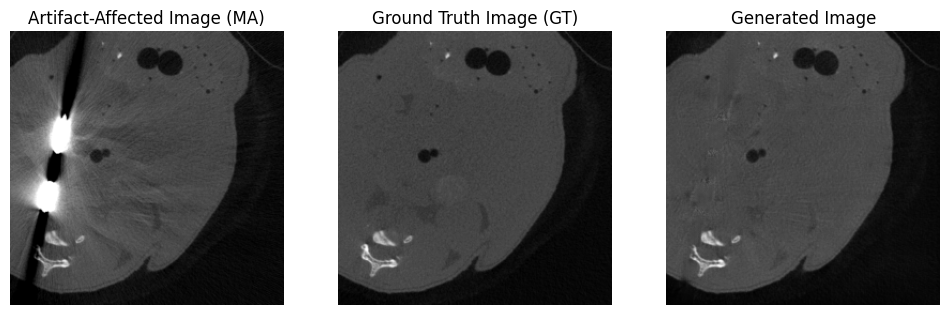

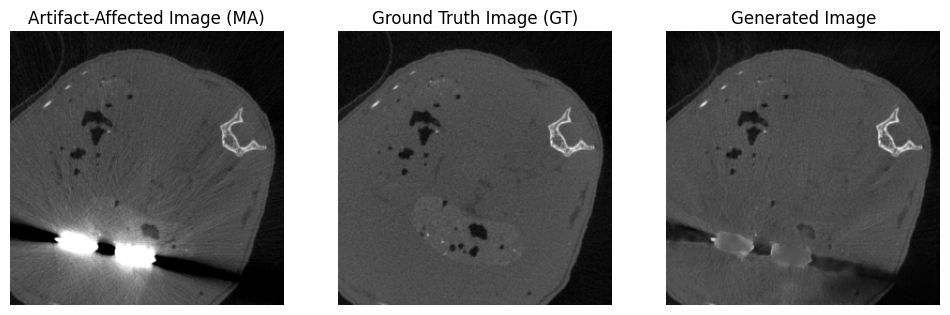

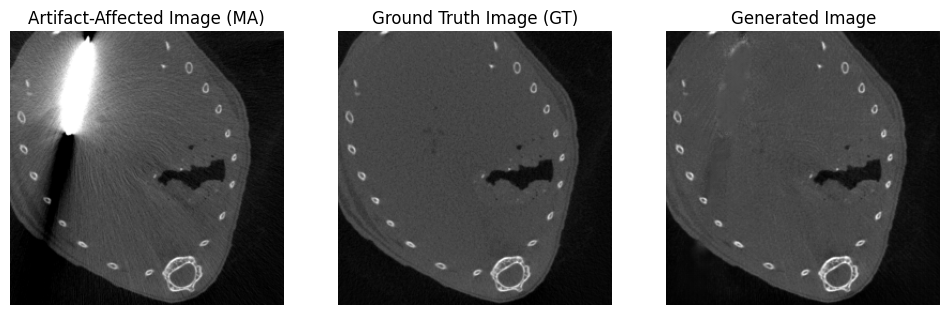

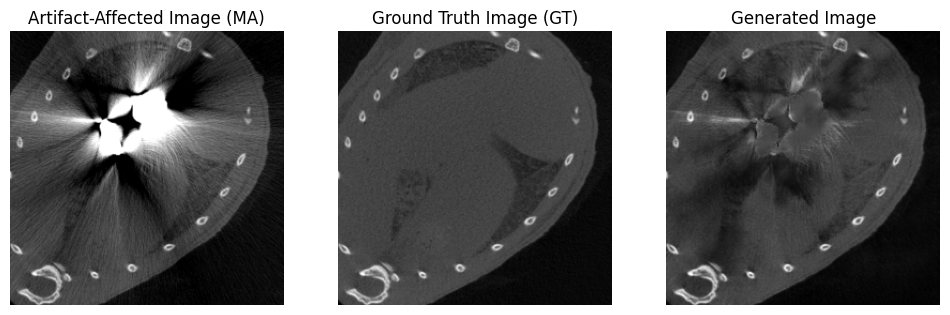

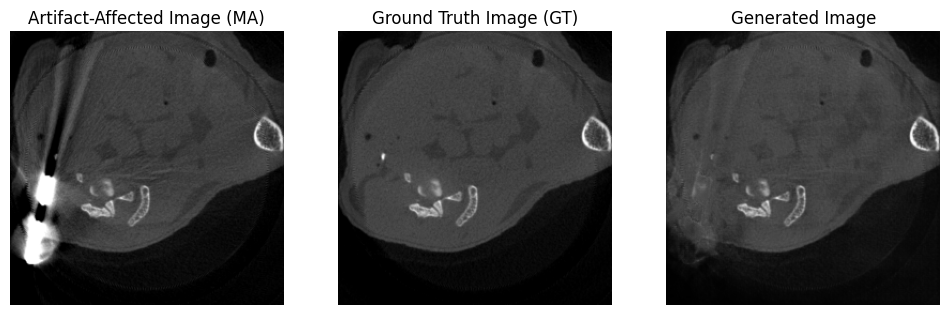

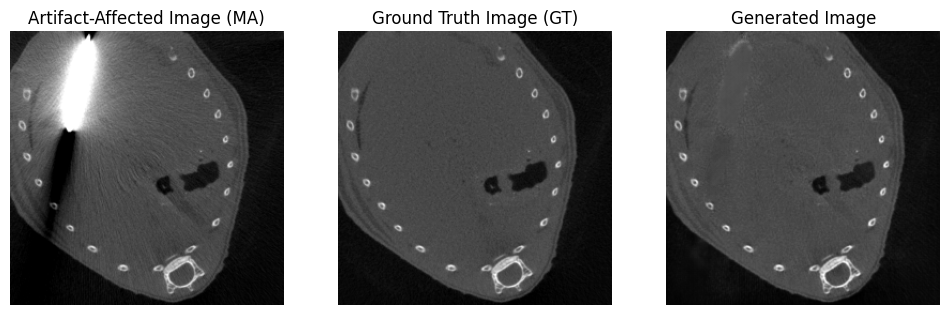

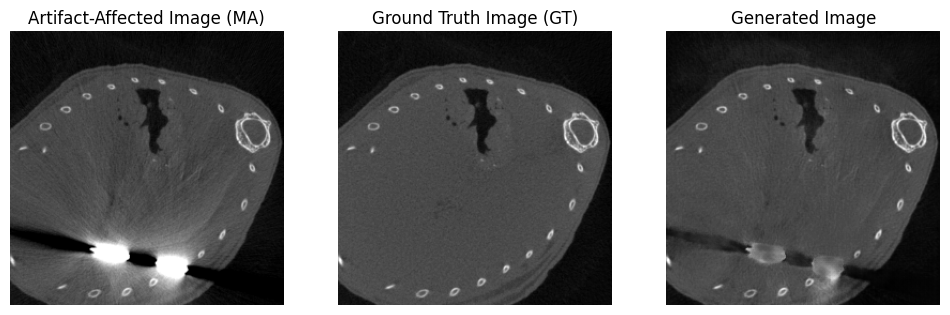

In [10]:
import os
import random
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from generator import UnetGenerator  # Assuming the generator architecture is in generator.py
from PIL import Image

# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained generator model
generator = UnetGenerator().to(device)
generator.load_state_dict(torch.load('generator.pt', map_location=device, weights_only=True))
generator.eval()  # Set model to evaluation mode

# Transformation to match training preprocessing (e.g., normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Inverse transform for visualization (to undo normalization)
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1], std=[2]),  # Reverse normalization if mean=0.5, std=0.5
    transforms.ToPILImage()
])

# Process PNG images
def process_png_image(ma_image_path, gt_image_path=None):
    # Load artifact-affected image
    ma_image = Image.open(ma_image_path).convert("L")  # Assuming grayscale images
    ma_tensor = transform(ma_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Generate the cleaned image
    with torch.no_grad():
        generated_tensor = generator(ma_tensor)

    # Remove batch dimension and apply inverse transform for visualization
    ma_image = inverse_transform(ma_tensor.squeeze(0).cpu())
    generated_image = inverse_transform(generated_tensor.squeeze(0).cpu())

    # If ground truth image is provided, load and process it
    gt_image = None
    if gt_image_path:
        gt_image = Image.open(gt_image_path).convert("L")  # Assuming grayscale images
        gt_tensor = transform(gt_image).unsqueeze(0).to(device)
        gt_image = inverse_transform(gt_tensor.squeeze(0).cpu())

    return ma_image, gt_image, generated_image

# Visualization function
def visualize_images(ma_image, gt_image, generated_image):
    plt.figure(figsize=(12, 4))
    
    # Plot artifact-affected image
    plt.subplot(1, 3, 1)
    plt.imshow(ma_image, cmap="gray")
    plt.title("Artifact-Affected Image (MA)")
    plt.axis("off")

    # Plot ground truth image if available
    if gt_image:
        plt.subplot(1, 3, 2)
        plt.imshow(gt_image, cmap="gray")
        plt.title("Ground Truth Image (GT)")
        plt.axis("off")

    # Plot generated image
    plt.subplot(1, 3, 3)
    plt.imshow(generated_image, cmap="gray")
    plt.title("Generated Image")
    plt.axis("off")

    plt.show()

# Process random 25 images from test directory
def process_random_images_from_test_directory(test_dir, num_images=25):
    metal_dir = os.path.join(test_dir, 'Metal')
    gt_dir = os.path.join(test_dir, 'GT')
    
    # Get all file names in the Metal directory
    all_files = [f for f in os.listdir(metal_dir) if os.path.isfile(os.path.join(metal_dir, f))]
    
    # Select a random sample of files
    selected_files = random.sample(all_files, min(num_images, len(all_files)))
    
    for filename in selected_files:
        ma_image_path = os.path.join(metal_dir, filename)
        gt_image_path = os.path.join(gt_dir, filename)  # Assume GT image has the same name
        
        # Check if corresponding GT image exists
        if os.path.exists(gt_image_path):
            # Process and visualize each image pair
            ma_image, gt_image, generated_image = process_png_image(ma_image_path, gt_image_path)
            visualize_images(ma_image, gt_image, generated_image)
        else:
            print(f"Warning: GT image for {filename} not found in {gt_dir}")

# Specify the test directory containing Metal and GT subdirectories
test_dir = "../../HISMAR/Dataset/test"

# Process and visualize random images in the test directory
process_random_images_from_test_directory(test_dir)

# Average PSNR and SSIM metrics for the test data

In [11]:
import os
import torch
from torchvision import transforms
from generator import UnetGenerator  # Assuming the generator architecture is in generator.py
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained generator model
generator = UnetGenerator().to(device)
generator.load_state_dict(torch.load('generator.pt', map_location=device, weights_only=True))
generator.eval()  # Set model to evaluation mode

# Transformation to match training preprocessing (e.g., normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Inverse transform for visualization (to undo normalization)
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1], std=[2]),  # Reverse normalization if mean=0.5, std=0.5
    transforms.ToPILImage()
])

# Process and evaluate PNG images
def process_and_evaluate_image(ma_image_path, gt_image_path):
    # Load artifact-affected image
    ma_image = Image.open(ma_image_path).convert("L")  # Assuming grayscale images
    ma_tensor = transform(ma_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Generate the cleaned image
    with torch.no_grad():
        generated_tensor = generator(ma_tensor)

    # Remove batch dimension and apply inverse transform
    generated_image = inverse_transform(generated_tensor.squeeze(0).cpu())

    # Load and process the ground truth image
    gt_image = Image.open(gt_image_path).convert("L")
    gt_tensor = transform(gt_image).unsqueeze(0).to(device)
    gt_image = inverse_transform(gt_tensor.squeeze(0).cpu())

    # Convert images to NumPy arrays for PSNR and SSIM calculation
    generated_np = np.array(generated_image)
    gt_np = np.array(gt_image)

    # Calculate PSNR and SSIM
    psnr_value = psnr(gt_np, generated_np, data_range=generated_np.max() - generated_np.min())
    ssim_value = ssim(gt_np, generated_np, data_range=generated_np.max() - generated_np.min())
    
    return psnr_value, ssim_value

# Calculate average PSNR and SSIM for the test directory
def calculate_average_metrics(test_dir):
    metal_dir = os.path.join(test_dir, 'Metal')
    gt_dir = os.path.join(test_dir, 'GT')
    
    psnr_total = 0.0
    ssim_total = 0.0
    num_images = 0
    
    # Iterate over images in the Metal directory
    for filename in os.listdir(metal_dir):
        ma_image_path = os.path.join(metal_dir, filename)
        gt_image_path = os.path.join(gt_dir, filename)  # Assume GT image has the same name

        # Check if the corresponding GT image exists
        if os.path.exists(gt_image_path):
            psnr_value, ssim_value = process_and_evaluate_image(ma_image_path, gt_image_path)
            psnr_total += psnr_value
            ssim_total += ssim_value
            num_images += 1
        else:
            print(f"Warning: GT image for {filename} not found in {gt_dir}")

    # Calculate average metrics
    avg_psnr = psnr_total / num_images if num_images > 0 else 0
    avg_ssim = ssim_total / num_images if num_images > 0 else 0

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

# Specify the test directory containing Metal and GT subdirectories
test_dir = "../../HISMAR/Dataset/test"

# Calculate and print average PSNR and SSIM
calculate_average_metrics(test_dir)

Average PSNR: 27.4839
Average SSIM: 0.8315
